<a href="https://colab.research.google.com/github/DaniFarias/Machine-Learning/blob/main/Processo_da_An%C3%A1lise_Preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Especialização em Ciência de Dados - FURG
## Machine Learning I - Processo da Análise Preditiva

Código adaptado de Aurélien Geron (licença Apache-2.0)

---

# Inicialização

Aqui importamos as bibliotecas fundamentais de Python para este _notebook_:

- NumPy: suporte a vetores, matrizes e operações de Álgebra Linear
- Matplotlib: biblioteca de visualização de dados
- Pandas: pacote estatístico e de manipulação de DataFrames
- Scikit-Learn: biblioteca com algoritmos de Machine Learning
- ScyPy: funções científicas diversas, incluindo estatísticas

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import scipy

# 1. Observar o quadro geral

O contexto deste projeto é o desenvolvimento de um sistema, usando Machine Learning, para **prever valores médios de casas em distritos da Califórnia**, considerando uma série de _features_ oriunda do censo destes distritos.

## 1.1 Contextualizar o problema

Para este projeto, a saída do modelo de Machine Learning alimentará outro sistema de ML, juntamente com muitos outros dados. Este segundo sistema determinará se vale a pena investir ou não no setor imobiliário de determinada área.

## 1.2 Qual a saída esperada?

Até o momento, os preços de habitação do distrito são estimados manualmente por especialistas, o que é caro e demorado. Além disso, ocorrem erros de previsão.

Uma vez que está disponível um conjunto de dados completo sobre tais distritos, incluindo dados econômicos, convém explorar um modelo de previsão baseado em ML. A saída é uma previsão de valores médios de casas para qualquer parte da Califórnia.

## 1.3 Enquadrar o problema

Esta é uma tarefa típica de **aprendizado supervisionado**, uma vez que já existem exemplos de treinamento rotulados (cada instância vem com o valor esperado, ou seja, o preço médio da habitação do distrito).

Também é uma tarefa típica de **regressão**, uma vez deseja-se prever um valor numérico.

Em particular, este é um  problema de **regressão múltipla**, pois o sistema usará várias _features_ para fazer uma previsão (população do distrito e renda média, por exemplo).

Também é um problema de **regressão univariada**, uma vez que deseja-se prever um único valor para cada distrito.
Se houvesse necessidade de prever vários valores por distrito, seria um problema multivariado.

Finalmente, não há fluxo contínuo de dados entrando no sistema, de forma que não há necessidade de se ajustar a dados variáveis rapidamente. Como os dados são pequenos o suficiente para caber na memória, é possível usar a estratégia de **aprendizado em lote**.

## 1.4 Selecionar uma medida de desempenho

Para este problema será utilizada a medida Root Mean Square Error: 

\begin{align}
\text{RMSE}(\textbf{X}, h) = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} \left( h(\textbf{x}^{(i)}) - y^{(i)} \right) ^2 }
\end{align}

Para comparação, também será utilizada a medida Mean Absolute Error:

\begin{align}
\text{MAE}(\textbf{X}, h) = \frac{1}{m} \sum_{i=1}^{m} \left| h(\textbf{x}^{(i)}) - y^{(i)} \right|
\end{align}

Quanto mais alto o expoente aplicado à diferente, mais o erro se concentra em grandes valores, negligenciando pequenos. É por isso que a RMSE é mais sensível a _outliers_ do que a MAE.

Porém, quando _outliers_ são mais raros (como em uma curva em forma de sino), a RMSE executa muito bem e geralmente é a medida preferida.

## 1.5 Verifique as premissas

Por exemplo, é preciso verificar se os preços previstos estão no formato adequado. No caso, devem ser valores numéricos, em dólares, e não categorias discretas.

# 2. Obter os dados

O conjunto de dados sobre preços de habitação da California é originário do repositório StatLib, e foi obtido de https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

Este conjunto de dados é baseado em dados da década de 1990. Mesmo não sendo recente, tem muitas boas qualidades de aprendizado. Também foi adicionado um atributo categórico e removidos alguns _features_ para ilustrar como trabalhar com valores faltantes.

Estas estatísticas são por grupo de quarteirões, que é a menor unidade geográfica para a qual o U.S. Census Bureau publica dados de amostra. Por simplicidade, um grupo de quarteirões é chamado de **distrito** nesta análise.

## 2.1 Examinar os dados

In [ ]:
# cada linha representa um distrito
housing = pd.read_csv('housing.csv')
housing.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY


In [ ]:
# visão geral
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Existem 20.640 instâncias no conjunto de dados, o que significa que é pequeno pelo padrão de Machine Learning, mas é perfeito como exemplo.

Observe que o atributo **total_bedrooms** tem apenas 20.433 valores não nulos, o que significa que 207 distritos não possuem este atributo. Isso precisa ser tratado posteriormente.

Todos os atributos são numéricos, exceto o campo **ocean_proximity**. Seu tipo é objeto, mas como veio de um arquivo CSV significa que é do tipo _string_. Mais ainda, como há muitas repetições, provavelmente é um atributo categórico.

In [ ]:
# exame de quantas são as categorias de 'ocean_proximity'
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
# resumo dos atributos numéricos
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


As linhas de contagem (**count**), média (**mean**), mínimo (**min**) e máximo (**max**) são autoexplicativas.

Valores nulos são ignorados.

A linha **std** mostra o desvio padrão, que mede a dispersão dos valores daquela coluna.

As linhas **25%**, **50%** e **75%** mostram os percentis correspondentes. Por exemplo, 25% dos distritos têm **housing_median_age** inferior a 18, enquanto 50% são inferiores a 29 e 75% são inferiores a 37. Estes são frequentemente chamados de 25º percentil (ou 1º quartil), mediana e 75º percentil (ou 3º quartil).

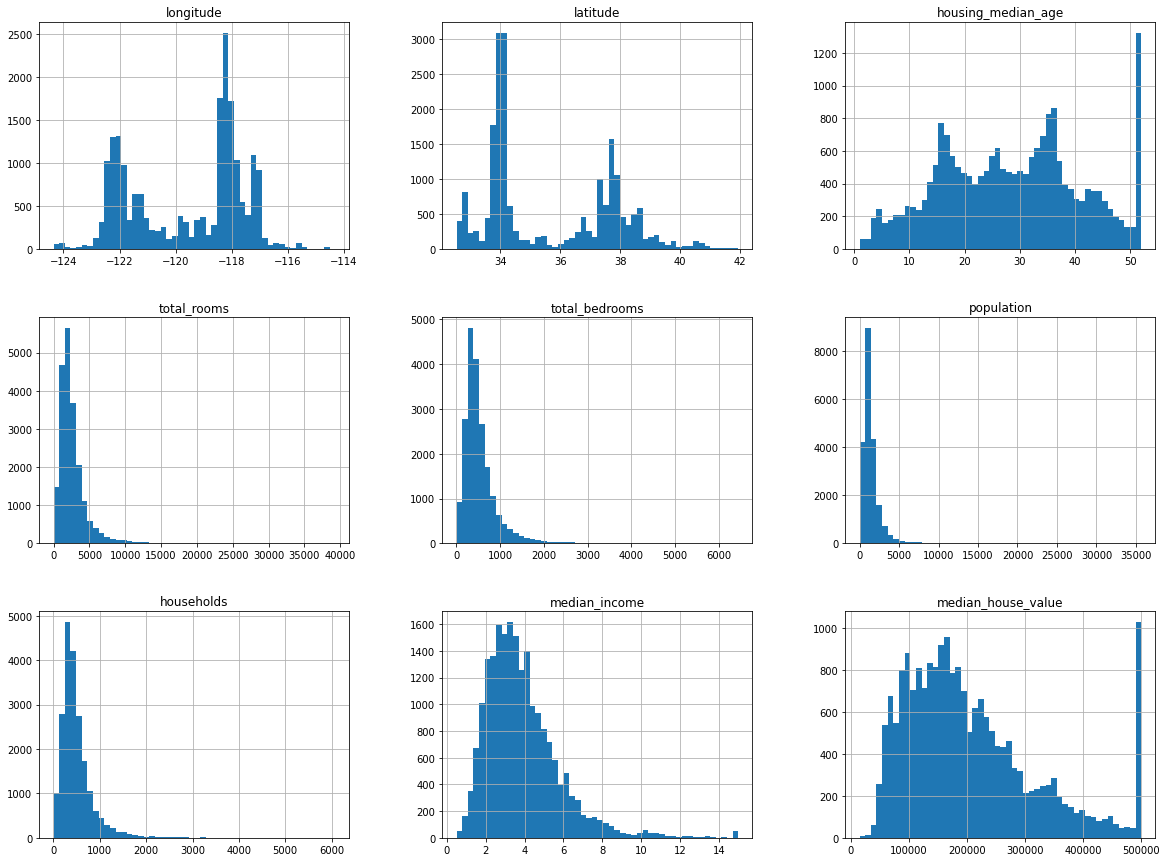

In [ ]:
# podemos mostrar os histogramas para observar a distribuição de todos os valores
housing.hist(bins=50, figsize=(20,15))
plt.show()

Pontos interessantes:

- O atributo **median_income** não está expresso em dólares americanos (USD), mas em milhares de dólares. E ainda foi limitado em 15.

- Os atributos **housing_median_age** e **median_house_value** também foram limitados, como é possível observar pelas altas contagens mais à direita nos respectivos histogramas.

- O limite de **median_house_value** precisa ser analisado, pois este é o atributo alvo (ou seja, o rótulo). Se for necessário gerar previsões além de 500.000, isso pode ser um problema. Uma solução seria obter novamente estes dados, com mais detalhes. Outra solução seria simplesmente remover este subconunto da base de dados.

- Os atributos têm escalas muito diferentes, o que será discutido posteriormente, quando for falado do dimensionamento das _features_.

- Muitos histogramas têm uma _longa cauda_ (são **tail heavy**): se estendem muito mais à direita da mediana do que à esquerda. Isso pode tornar mais difícil que algoritmos de ML detectem padrões. A solução é transformar esses atributos para ter distribuições em forma de sino.

## 2.2 Criar um conjunto de testes

Antes de examinar os dados mais a fundo, é necessário criar o conjunto de teste.

Idealmente ele será criado e deixado de lado até mais tarde. Analisar o conjunto de teste pode causar um viés no processo de análise e eventualmente afetar as medidas de desempenho.

### Amostragem aleatória

In [ ]:
# para garantir um resultado idêntico a cada execução deste notebook, 
# iniciamos a geração de números aleatórios com a mesma semente (seed)
np.random.seed(42)

In [ ]:
# exemplo de função simples para separar dados em treino e teste
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
print('train set:', len(train_set))
print('test set: ', len(test_set))

train set: 16512
test set:  4128


In [ ]:
# a biblioteca scikit-learn já inclui uma função de separação randomizada, muito semelhante à anterior
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print('train set:', len(train_set))
print('test set: ', len(test_set))

train set: 16512
test set:  4128


Uma abordagem melhor é calcular um _hash_ do identificador de cada instância e colocar essa instância
no conjunto de teste se este _hash_ for menor ou igual a 20% do valor máximo da função _hash_.

Isso garante que o conjunto de teste permanecerá consistente através de várias execuções, mesmo se o conjunto de dados for atualiado. O novo conjunto de teste conterá 20% das novas instâncias, mas não conterá nenhuma instância que estava anteriormente no conjunto de treinamento.

In [ ]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Este conjunto de dados de habitação não tem uma coluna com um identificador. Uma solução simples é usar o índice de linha como este ID.

Nesse caso, é preciso se certificar de que os novos dados são anexado ao final do conjunto de dados e que nenhuma linha anterior seja excluída.

In [ ]:
# adiciona uma coluna chamada 'index' e faz a separação
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
print('train set:', len(train_set))
print('test set: ', len(test_set))

train set: 16362
test set:  4278


Uma solução mais robusta é usar as _features_ mais estáveis para construir um identificador único.

Neste caso, a latitude e longitude de um distrito têm garantia de estabilidade, então podem ser combinadas em um ID numérico.

In [ ]:
# adiciona uma coluna chamada 'id' e faz a separação
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print('train set:', len(train_set))
print('test set: ', len(test_set))

train set: 16267
test set:  4373


In [ ]:
test_set.head(4)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15


### Amostragem estratificada

A amostragem aleatória é adequada quando o conjunto de dados é grande (especialmente em relação ao número de atributos), mas se não for, há o risco de introduzir um significativo **viés de amostragem** (_sampling bias_).

Para evitar isso podemos fazer uma **amostragem estratificada**, levando em conta a frequência dos atributos presentes nos dados. A ideia é criar conjuntos de treino e de testes que sejam estatisticamente representativos em relação a toda a base de dados.

Isso será feito para o atributo **median_income**, ao agrupar faixas de valores em **estratos** (_strata_).

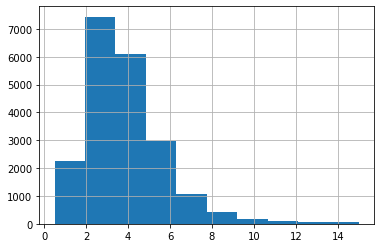

In [ ]:
housing['median_income'].hist()
plt.show()

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

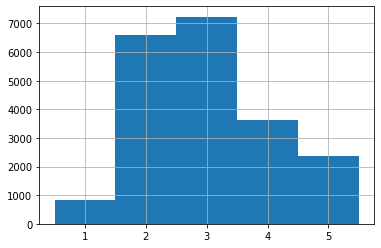

In [ ]:
housing['income_cat'].hist(bins=5, range=(1,6), align='left')
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# usa amostragem estratificada para separar os dados em treino e teste
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print('train set:', len(strat_train_set))
print('test set: ', len(strat_test_set))

train set: 16512
test set:  4128


In [ ]:
# percentuais por estrato para 'median_income' no conjunto de treino
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [ ]:
# percentuais por estrato para 'median_income' no conjunto de teste
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
# percentuais no conjunto de dados completo
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

A seguir, uma breve comparação da diferença entre os conjunto original e os conjuntos de teste obtidos com amostragem aleatória e amostragem estratificada.

In [ ]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    'Overall':    income_cat_proportions(housing),
    'Random':     income_cat_proportions(test_set),
    'Stratified': income_cat_proportions(strat_test_set),
}).sort_index()
compare_props['Rand. %error']  = 100 * compare_props['Random']     / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1,0.039826,0.040213,0.039971,0.973236,0.364964
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114341,-4.318374,-0.084674


In [ ]:
# para finalizar, será removido o atributo auxiliar 'income_cat' dos conjuntos de treino e teste
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 3. Analisar e visualizar os dados de treino

O conjunto de teste será guardado para mais tarde, e uma cópia será feira para explorar melhor os dados de treino.

In [ ]:
# note que o DataFrame 'housing' a partir de agora é uma cópia dos dados de treino estratificados
housing = strat_train_set.copy()

## Visualização de dados geográficos

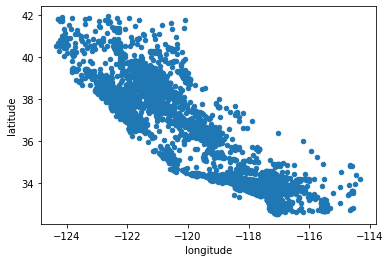

In [ ]:
# uma plotagem usando um gráfico de dispersão permite ver a distribuição geográfica das instâncias
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

Esse tipo de exibição tem limitações, principalmente pela sobreposição de informações. Ao se usar transparência, temos uma percepção melhor da densidade dos dados.

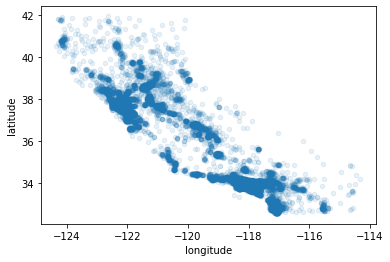

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

Agora uma visualizando incluindo os preços das casas.

O raio de cada círculo representa a população do distrito (parâmetro **s**), enquanto a cor representa o preço (parâmetro **c**). A figura uma um mapa de cores predefinido (parâmetro **cmap='jet'**), que varia do azul
(preços baixos) para vermelho (preços altos).

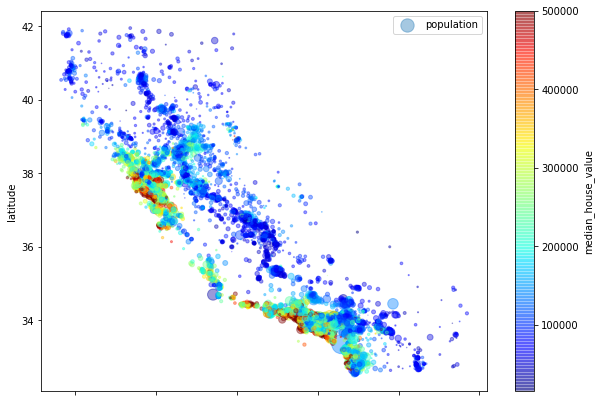

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap='jet', colorbar=True)
plt.legend()
plt.show()

O código abaixo lê a imagem **california.png** e a usa como fundo para o gráfico, ilustrando melhor as fronteiras do estado e as regiões de oceano.

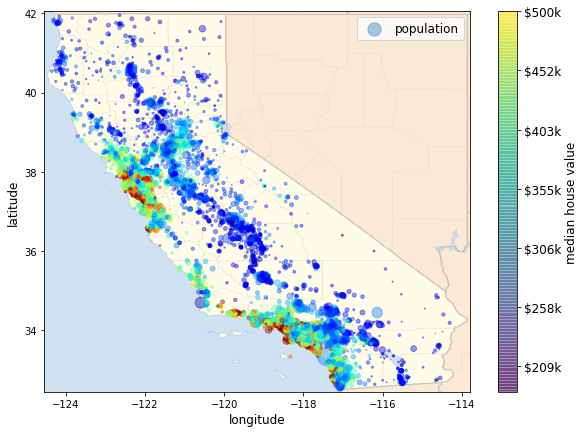

In [ ]:
import matplotlib.image as mpimg

# gráfico de dispersão
ax = housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,7),
                  s=housing['population']/100, label='population',
                  c='median_house_value', cmap='jet', colorbar=False, alpha=0.4)
plt.ylabel('latitude', fontsize=12)
plt.xlabel('longitude', fontsize=12)

# imagem de fundo
california_img = mpimg.imread('california.png')
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)

# barra de valores
prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=12)
cbar.set_label('median house value', fontsize=12)

plt.legend(fontsize=12)
plt.show()

## Procurando por correlações entre atributos

Como o conjunto de dados não é grande, pode-se calcular facilmente o coeficiente de correlação (também chamado de R de Pearson) entre cada par de atributos usando a função **corr()** de um DataFrame.

In [ ]:
corr_matrix = housing.corr()

In [ ]:
# quanto cada atributo se correlaciona com o valor de 'median_house_value'
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

O coeficiente de correlação varia de -1 a 1.

Quando está próximo de 1, significa que existe uma forte correlação positiva. Neste exemplo, o atributo de valor das casas tende a aumentar quando a renda média aumenta.

Quando o coeficiente está próximo de -1, significa que existe uma forte correlação negativa.

Finalmente, um coeficiente de 0 indica que não há correlação linear. Note que não haver correlação linear não exclui a existência de correlações mais complexas entre os dados.

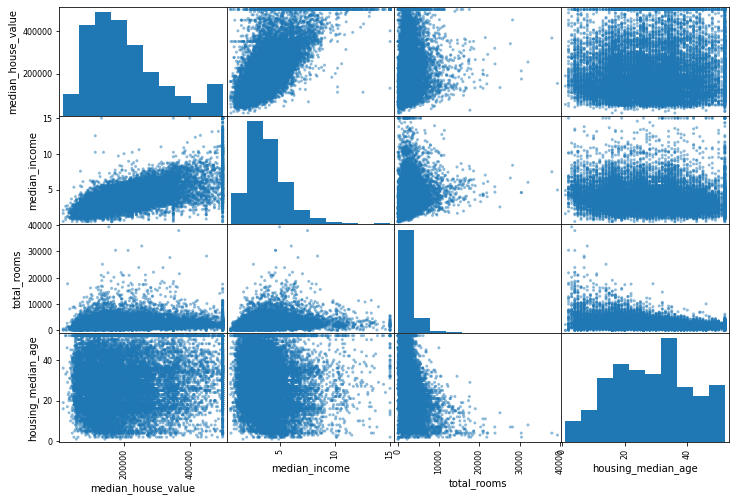

In [ ]:
# a biblioteca Pandas permite exibir graficamente pares de atributos em uma matriz
from pandas.plotting import scatter_matrix

# aqui apenas alguns, mais promissores, são selecionados
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Note que na diagonal da matriz acima são mostrados os histogramas de distribuição de cada atributo.

Como o atributo mais promissor para prever o valor mediano das casas é a mediana de renda, abaixo é mostrado um gráfico específico para esta relação.

A correlação positiva entre ambos atributos é bem clara, assim como o efeito de limitação do valor máximo das casas. E também são discerníveis linhas horizontais para algumas faixas de valores das casas.

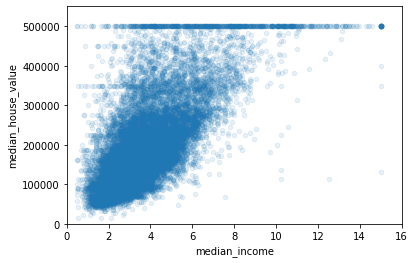

In [ ]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

## Experimentar com combinações entre atributos

É conveniente experimentar várias combinações de atributos, que talvez tragam mais clareza sobre os dados.

Por exemplo, o número total de cômodos em um distrito não é muito útil quando não se sabe quantas famílias existem. Faz mais sentido ter o número de cômodos por casa.

Da mesma forma, o número total de quartos de dormir por distrito por si só não é muito útil: faz sentido compará-lo com o número de cômodos. E a população por domicílio também parece uma combinação de atributos interessante de se olhar.

Esse novos atributos serão criados a seguir.

In [ ]:
housing['rooms_per_household']      = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room']        = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

O novo atributo **bedrooms_per_room** está muito mais relacionado com o valor mediano das casas do que o número total de cômodos ou quartos de dormir. Então casas com uma relação quarto / cômodo menor tendem a ser mais caras.

O número de quartos por domicílio (**rooms_per_household**) também é mais informativo do que o número total de quartos em um distrito (quanto maiores as casas, mais caras elas são).

Essa rodada de exploração não precisa ser completa; o objetivo é obter percepções que ajudem a construir uma boa análise inicial. Este é um processo iterativo: uma vez criado um protótipo de ML, sua saída pode ser analisada para obter mais _insights_, voltando a esta etapa.

# 4. Preparar os dados para os algoritmos de Machine Learning

In [ ]:
# aqui o dataset é restaurado do ponto onde foi criado o conjunto de treino, separando também os rótulos
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [ ]:
housing.describe

## 4.1 Limpeza dos dados

A maioria dos algoritmos de ML não funciona com _features_ ausentes, então é necessário criar algumas funções para cuidar disso.

No caso específico, o atributo **total_bedrooms** tem alguns valores faltando.

In [ ]:
housing[housing.isnull().any(axis=1)].head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN


São três as opções:

1. Remover os distritos correspondentes: 

       housing.dropna(subset=['total_bedrooms'])

2. Remover completaee de todo o atributo:

       housing.drop('total_bedrooms', axis=1)

3. Definir os valores faltantes para algum novo valor (zero, a média, a mediana, etc.):

       median = housing['total_bedrooms'].median()
       housing['total_bedrooms'].fillna(median, inplace=True)
       
Note que na opção 3 este valor de substituição teria que ser posteriormente aplicado para os dados de teste também, além dos novos dados de entrada.

In [ ]:
# a biblioteca scikit-learn permite computar e fazer a substituição automaticamente
from sklearn.impute import SimpleImputer

# estratégia de uso da mediana
imputer = SimpleImputer(strategy='median')

# como a mediana apenas funciona em valores numéricos, é necessária uma base sem o atributo 'ocean_proximity'
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

# os valores computados são guardados neste objeto
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [ ]:
# por garantia, comparamos com o cálculo manual da mediana para os mesmos atributos
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

O novo conjunto de treino, transformado, pode ser criado:

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264


## 4.2 Lidando com textos e atributos categóricos

O atributo categórico **ocean_proximity** foi deixado de fora porque não é possível calcular sua mediana.

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(4)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN


Como a maioria dos algoritmos de Machine Learning prefere trabalhar com números, podemos converter essa categoria de texto para número. Para isso, podemos usar a classe `OrdinalEncoder`.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# resultado codificado
housing_cat_encoded[:4]

array([[1.],
       [4.],
       [1.],
       [4.]])

In [ ]:
# categorias que foram codificadas
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Um problema com esta representação é que os algoritmos de ML irão assumir que dois valores numericamente próximos
são mais semelhantes do que dois valores distantes.

Isso pode ser bom em alguns casos (por exemplo, para categorias ordenadas como "ruim", "médio", "bom", "excelente"), mas não é o caso da coluna **ocean_proximity**.

Para corrigir esse problema, uma solução comum é criar um atributo binário por categoria: um atributo igual a 1 quando a categoria é **<1H OCEAN** (e 0 caso contrário), outro atributo igual a 1 quando a categoria é
**INLAND** (e 0 caso contrário), e assim por diante.

Isso é chamado de codificação distribuída (_one-hot_), porque apenas um atributo será igual a 1 (quente), enquanto os outros serão 0 (frio).

In [ ]:
# o codificador OneHotEncoder permite converter valores categóricos em vetores one-hot
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# categorias que foram codificadas
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 4.3 Escalonamento de _features_

Uma das transformações mais importantes que precisa ser aplicada aos dados é o **escalonamento de _features_**.

Com poucas exceções, os algoritmos de aprendizado de máquina não funcionam bem quando os atributos numéricos de entrada têm escalas muito diferentes. Entretanto, redimensionar os valores alvo geralmente não é requerido.

Existem duas maneiras comuns de fazer com que todos os atributos tenham a mesma escala: escalonamento min-max
e padronização.

O **escalonamento min-max** (também chamado de **normalização**) é bastante simples: os valores são deslocados e reescalonados de modo que acabem variando de 0 a 1. Fazemos isso subtraindo o valor mínimo e dividindo pelo máximo menos o mínimo. A classe `MinMaxScaler` provê um transformador para isso.

A **padronização** é bem diferente: primeiro, esta subtrai o valor médio e então divide pelo desvio padrão, para que a distribuição resultante tenha média zero e variância unitária. A classe `StandardScaler` fornece um transformador para fazer a padronização.

## 4.4 Pipelines de transformação

Existem muitas etapas de transformação de dados que precisam ser executadas em certa ordem certa.

Para isto, o a biblioteca Scikit-Learn fornece a classe `Pipeline` para ajudar com tais sequências de transformações.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# pipeline para dados numéricos
num_pipeline = Pipeline([
    ('imputer',       SimpleImputer(strategy='median')),
    ('std_scaler',    StandardScaler()),
])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# pipeline combinando dados numérico com atributo categórico
full_pipeline = ColumnTransformer([
        ("num", num_pipeline,    num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
# estes são os dados de treino já preparados (e com colunas adicionais)
housing_prepared.shape

(16512, 13)

# 5. Selecionar e treinar um modelo

## 5.1 Treinar e avaliar um modelo

In [ ]:
# aqui vai ser utilizado um modelo simples de Regressão Linear
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
# pipeline inteiro para algumas instâncias
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]
some_data_prepared = full_pipeline.transform(some_data)

print('previsões:    ', lin_reg.predict(some_data_prepared))
print('valores reais:', list(some_labels))

previsões:     [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102]
valores reais: [72100.0, 279600.0, 82700.0, 112500.0]


In [ ]:
# usando a medida de desempenho RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.56219504567

In [ ]:
# usando a medida de desempenho MAE
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49905.329442715316

Claramente não é uma boa pontuação: na maioria dos distritos **median_housing_value** varia entre 120.000 e 265.000, então uma previsão típica erro 68.628 ou mesmo 49.439 não é satisfatória.

Este é um exemplo de _underfitting_ dos dados de treinamento. Quando isso acontece, pode significar que os recursos não fornecem informações suficientes para fazer boas previsões, ou que o modelo não é poderoso o suficiente.

In [ ]:
# aqui um modelo de Árvore de Decisão
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [ ]:
# usando a medida de desempenho RMSE
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Erro zero indica muito provavelmente que o modelo tenha superestimado os dados. Ou seja, um caso de _overfitting_.

Note que o correto é **somente usar o conjunto de teste quando haja confiança em um modelo já treinado**.

Então é necessário usar parte do conjunto de treinamento para treinar e parte para validação do modelo, o que é chamado de validação cruzada (_cross validation_).

## 5.2 Avaliar usando validação cruzada

Esta validação pode ser manualmente quebrando o conjunto de treino em partes menores e criando modelos separados, que são avaliados também separadamente.

Este é um processo muito comum de Machine Learning, e pode ser efetuado automaticamente usando `cross_val_score`.

O código a seguir divide aleatoriamente o conjunto de treinamento em 10 subconjuntos distintos chamados dobras (_folds_) e em seguida, treina e avalia o modelo de árvore de decisão 10 vezes.

O processo escolhe uma dobra diferente para avaliação em cada vez, utilizando as outras 9 dobras para treinamento. O resultado é um vetor contendo as 10 pontuações de avaliação.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# validação cruzada para o modelo de Árvore de Decisão criado anteriomente
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print("Scores:", scores)
print("Mean:  ", scores.mean())
print("Std:   ", scores.std())

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean:   69081.361562518
Std:    2296.288087393378


A validação cruzada permite obter não apenas uma estimativa do desempenho do modelo, mas também uma medida
de quão precisa essa estimativa é (ou seja, seu desvio padrão).

Essa informação não seria possível sem uma sistemática de validação. Mas a validação cruzada vem com o custo de treinar o modelo várias vezes, o que pode ser um limitante.

In [ ]:
# validação cruzada para o modelo de Regressão Linear criado anteriomente
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print("Scores:", scores)
print("Mean:  ", scores.mean())
print("Std:   ", scores.std())

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean:   69204.32275494764
Std:    2372.070791055919


De fato o modelo da Árvore de Decisão está fazendo _overfitting_, tanto que tem um desempenho pior
do que o modelo de Regressão Linear.

### Modelo Ensemble

Aqui será testado mais um modelo, `RandomForestRegressor`.

Como será visto posteriormente, Florestas Aleatórias trabalham treinando muitas Árvores de Decisão em subconjuntos aleatórios de _features_ e, em seguida, calculando a média de suas previsões.

A construção de um modelo em cima de muitos outros modelos é chamadas de Ensemble Learning (significando aprendizado por comitê ou agregação).

In [ ]:
# aqui um modelo de Floresta Aleatória -- demora um pouco mais que os anteriores
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [ ]:
# usando a medida de desempenho RMSE
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18342.366362322846

In [ ]:
# validação cruzada para o modelo de Floresta Aleatória criado anteriomente -- demora um pouco mais
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print("Scores:", scores)
print("Mean:  ", scores.mean())
print("Std:   ", scores.std())

Scores: [51039.08053738 48741.94041426 45940.42771745 50501.41453432
 47387.7896427  49595.25845731 51625.68567717 48865.70709952
 47322.87631489 53301.08748462]
Mean:   49432.12678796127
Std:    2124.8587921578355


Note que apesar do erro da Floresta Aleatória para todos os dados de treino ser menor, pela validação cruzada é possível perceber que o modelo ainda não é bom o suficiente.

Isso indica que o primeiro resultado também teve _overfitting_.

### DICA:

Cada modelo que foi treinado pode ser salvo e recuperado, para que se possa ser facilmente reutilizado e comparado a outros. Um recurso útil para isso é o módulo `joblib`. Por exemplo

    from sklearn.externals import joblib
    
    joblib.dump(my_model, 'my_model.pkl')
    # e depois...
    my_model_loaded = joblib.load('my_model.pkl')

# 6. Ajustar o modelo

O processo de escolha de hiperparâmetros pode ser automatizado, por exemplo usando a classe `GridSearchCV`.

## Grid Search

Basta indicar quais hiperparâmetros deverão ser experimentado e quais valores serão testados. Esta classe irá  avaliar todas as combinações possíveis de valores de hiperparâmetros, usando validação cruzada.

In [ ]:
from sklearn.model_selection import GridSearchCV

# especificação de hiperparâmetros e suas variações
param_grid = [
    # vai tentar 12 (3×4) combinações de hiperparâmetros
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # então vai tentar 6 (2×3) combinações com 'bootstrap=False'
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# modelo de Floresta Aleatória
forest_reg = RandomForestRegressor(random_state=42)

# treinamento usando 5 dobras, o que dá um total de (12+6)*5=90 rodadas de treinamento
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Aqui está a melhor combinação de hiperparâmetros encontrada:

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Aqui estão todas as pontuações das combinações hiperparâmetros testadas durante a busca em _grid_:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63827.76261554265 {'max_features': 2, 'n_estimators': 3}
55056.82212305312 {'max_features': 2, 'n_estimators': 10}
52673.5498401615 {'max_features': 2, 'n_estimators': 30}
60299.48845134689 {'max_features': 4, 'n_estimators': 3}
53106.41271952157 {'max_features': 4, 'n_estimators': 10}
50370.55528306362 {'max_features': 4, 'n_estimators': 30}
58363.22748437211 {'max_features': 6, 'n_estimators': 3}
52446.057900340325 {'max_features': 6, 'n_estimators': 10}
50177.91173851986 {'max_features': 6, 'n_estimators': 30}
58058.12321723554 {'max_features': 8, 'n_estimators': 3}
51849.42681935635 {'max_features': 8, 'n_estimators': 10}
49941.11534754462 {'max_features': 8, 'n_estimators': 30}
62820.05402812565 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53846.18083156347 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59026.17902108823 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52996.55803561763 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

## Randomized Search

A abordagem de pesquisa em grade é boa quando se está explorando relativamente poucas combinações, mas quando o espaço de pesquisa do hiperparâmetro é grande, é frequentemente preferível usar `RandomizedSearchCV`.

Esta classe pode ser usada da mesma forma que a classe `GridSearchCV`, mas em vez de tentar todas as combinações possíveis, esta avalia apenas um determinado número de combinações aleatórias, selecionando um valor para cada hiperparâmetro em cada iteração.

Esta abordagem tem dois benefícios principais:

- Se a pesquisa aleatória for executada por 1.000 iterações, por exemplo, esta abordagem irá explorar 1.000 valores diferentes para cada hiperparâmetro (em vez de apenas alguns valores por hiperparâmetro, com na pesquisa em grade).

- É possível ter mais controle sobre a quantidade de processamento a ser gasta com a pesquisa de hiperparâmetros, simplesmente definindo o número de iterações.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8f8f04ed10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8f8f04e750>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49121.49837525519 {'max_features': 7, 'n_estimators': 180}
51272.09460120037 {'max_features': 5, 'n_estimators': 15}
50535.37125677256 {'max_features': 3, 'n_estimators': 72}
50689.968708041284 {'max_features': 5, 'n_estimators': 21}
49129.57573326101 {'max_features': 7, 'n_estimators': 122}
50491.86588833997 {'max_features': 3, 'n_estimators': 75}
50414.569062947536 {'max_features': 3, 'n_estimators': 88}
49462.00096652969 {'max_features': 5, 'n_estimators': 100}
50200.230149209325 {'max_features': 3, 'n_estimators': 150}
64800.37553997819 {'max_features': 5, 'n_estimators': 2}


## Analisar os melhores modelos e seus erros

Bons _insights_ sobre o problema podem ser obtidos ao se inspecionar os melhores modelos.

Por exemplo, o `RandomForestRegressor` pode indicar a importância relativa de cada atributo para fazer previsões precisas, como mostrado abaixo.

In [ ]:
# usando os resultados da busca em grade
feature_importances = grid_search.best_estimator_.feature_importances_
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4514229299024067, 'median_income'),
 (0.1531772715909896, 'INLAND'),
 (0.10578455467355671, 'longitude'),
 (0.09776084745397103, 'latitude'),
 (0.05055515835391469, 'housing_median_age'),
 (0.04062593190523444, 'population'),
 (0.030411697118467456, 'total_rooms'),
 (0.026935686293612926, 'total_bedrooms'),
 (0.026385094002886144, 'households'),
 (0.01042996551503031, '<1H OCEAN'),
 (0.004901056539401569, 'NEAR OCEAN'),
 (0.0015941708346023547, 'NEAR BAY'),
 (1.563581592618151e-05, 'ISLAND')]

Com essas informações é possível eliminar alguns dos recursos menos úteis (por exemplo, aparentemente, apenas uma categoria **ocean_proximity** é realmente útil, então pode-se tentar abandonar as demais).

Também deve-se olhar para os erros específicos que o sistema comete e então tentar entender entender por que isso aconteceu e o que poderia ser feito para resolver o problema (adicionar recursos extras, livrar-se dos dados não informativos, limpar outliers, etc.).

# 7. Avaliar o modelo final

Nesta etapa finalmente são usados o dados de teste. Atente para o uso de `full_pipeline.transform()` para os dados de teste, ao invés de `full_pipeline.fit_transform()`, usado apenas para os dados de treino.

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47859.544319108194

Podemos calcular um intervalo de confiança de 95% para o teste RMSE:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45909.04350565, 49733.6072416 ])